# 1. Introdução
------
Este notebook tem por objetivo demonstrar alguns casos de base em matrizes maiores. Para verificar os casos de base com matrizes fundamentais, veja o notebook [aqui](https://github.com/rsautter/GPA/tree/master/Examples/FundamentalMatrix.ipynb).

Neste notebook é apresentado a função de [densidade de probabilidade da distribuição normal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal) e a função de [Bessel](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_Bessel) para os casos de padrões simétricos. Também é apresentado os [ruídos coloridos](http://adsabs.harvard.edu/pdf/1995A%26A...300..707T) e o [ruído de Perlin](https://en.wikipedia.org/wiki/Perlin_noise).



Rode a célula a seguir, caso esteja utilizando o colab. As células a seguir instalam as bibliotecas GPA, ruído colorido e ruído de Perlin. 

In [1]:
!pip install git+https://github.com/rsautter/GPA@V4

  Cloning https://github.com/rsautter/GPA (to revision V4) to /tmp/pip-req-build-8b0y_b38
  Running command git clone -q https://github.com/rsautter/GPA /tmp/pip-req-build-8b0y_b38
  Running command git checkout -b V4 --track origin/V4
  Switched to a new branch 'V4'
  Branch 'V4' set up to track remote branch 'V4' from 'origin'.
  Created wheel for GPA: filename=GPA-4.0-py3-none-any.whl size=6848 sha256=181e7965a56f6eeb0fd3556120f26d6adea169280640bea0d4ae4f6a498e45a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-xbs6vg99/wheels/01/38/8c/486d2777ffb87ef75c1e4c2e337125cd566f094df5fe460043
Successfully built GPA


In [2]:
!pip install git+https://github.com/felixpatzelt/colorednoise

  Cloning https://github.com/felixpatzelt/colorednoise to /tmp/pip-req-build-nlmekj0u
  Running command git clone -q https://github.com/felixpatzelt/colorednoise /tmp/pip-req-build-nlmekj0u
  Created wheel for colorednoise: filename=colorednoise-1.1.1-py3-none-any.whl size=3983 sha256=865cd677095310aa6dc3c2644776549c65a5ffe7f361be00a62696544db9d66e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qy0vcq7x/wheels/7f/3c/21/fa3c970cd6a300acbcaab0f9daf92719d9bda392f0162619ac
Successfully built colorednoise


A célula a seguir invoca as bibliotecas de manipulação de vetores, geradora de casos base da física e estatística, plotagem e o próprio GPA 

In [4]:
from GPA3D import GPA3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches
import tqdm as tqdm

# bibliotecas que geram funcoes
import scipy.stats as stats
import scipy.special as special

# bibliotecas de ruidos
import colorednoise as cn

# Para o novo ruido
from scipy.ndimage.filters import gaussian_filter1d
import scipy.signal as signal

### Criando um objeto

In [5]:
ga = GPA3D(0.05)

### Plot com classificação

In [ ]:
from matplotlib.patches import FancyArrowPatch, Patch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plotGPAVecClass(mat,ga,scale = 0.5):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
 
    x, y, z = np.indices(np.array(ga.gradient_dx.shape)+1)
    filled = np.ones((ga.gradient_dx.shape))
    print(filled.shape)
    ax.voxels(x,y,z,filled, facecolors=[0,0,0,0], edgecolor='black',lw=0.5)


    for x in range(ga.gradient_dx.shape[0]):
      for y in range(ga.gradient_dx.shape[1]):
        for z in range(ga.gradient_dx.shape[2]):
          if ga.asymmetricalP[x,y,z] ==1:
            arrow = Arrow3D([x+0.5, x+scale*ga.gradient_dx[x,y,z] +0.5], [y+0.5, y+scale*ga.gradient_dy[x,y,z]+0.5 ], [z+0.5, z+scale*ga.gradient_dz[x,y,z]+0.5 ],
                          mutation_scale=30, shrinkA=1.5, shrinkB=1.5, color='r')
          elif ga.symmetricalP[x,y,z] == 1:
            arrow = Arrow3D([x+0.5, x+scale*ga.gradient_dx[x,y,z] +0.5], [y+0.5, y+scale*ga.gradient_dy[x,y,z]+0.5 ], [z+0.5, z+scale*ga.gradient_dz[x,y,z]+0.5 ],
                          mutation_scale=30, shrinkA=1.5, shrinkB=1.5, color='b')
          else:
            arrow = Arrow3D([x+0.5, x+scale*ga.gradient_dx[x,y,z] +0.5], [y+0.5, y+scale*ga.gradient_dy[x,y,z]+0.5 ], [z+0.5, z+scale*ga.gradient_dz[x,y,z]+0.5 ],
                          mutation_scale=30, shrinkA=1.5, shrinkB=1.5, color='k')
          ax.add_artist(arrow)
    
    ax.legend(handles=[
                        Patch(color='blue', label='Symmetric'),
                        Patch(color='red', label='Asymmetric'),
                        Patch(color='black', label='Unknown')], fontsize=15)
  
    ax.set_xlim(0,ga.gradient_dx.shape[0])
    ax.set_ylim(0,ga.gradient_dx.shape[1])
    ax.set_zlim(0,ga.gradient_dx.shape[2])
    ax.set_axis_off()
    plt.tight_layout()
          
    plt.show()

# 2. Gauss
-----

Um exemplo notório de matriz para estudo de padrões é a distribuição de densidade de probabilidade da distribuição (PDF) normal. A função é dada por:

$$ f(x) = {1 \over \sigma \sqrt{2\pi}} e^{-{1\over 2} \left({x-\mu \over \sigma}\right)^2}$$

Nesta função $\mu$ é a média, que determina a localização do máximo da função, e $\sigma$ é o desvio padrão. Na implementação da [signal.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), o parâmetro $\mu$ é chamado loc e $\sigma$ é chamado scale.  


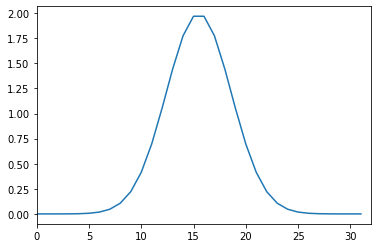

In [ ]:
x = np.linspace(-1,1,32)
gauss1D = stats.norm(loc=0.0,scale=0.2).pdf(x)
plt.figure()
plt.plot(gauss1D)
plt.xlim(0,len(gauss1D))
plt.show()

Para gerar a matriz que corresponde a distribuição PDF normal, precisamos primeiramente mapear em cada elemento da matriz  a distância correspondente, para então aplicar a função. A matriz de distâncias foi calculada utilizado a função [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html), em combinação a funções vetoriais que calculam a distância euclidiana.

Uma alternativa seria gerar uma PDF normal unidimensional e aplicar o produto externo para gerar uma matriz de PDF normal. 

In [ ]:
x = np.linspace(-1.0,1.0,32)
dx,dy,dz = np.meshgrid(x,x,x)
x3D = np.sqrt(dx**2+dy**2+dz**2)

gauss3D = stats.norm(loc=0.0,scale=0.2).pdf(x3D)


A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nulo, uma vez que não há vetores assimétricos. Enquanto o primeiro e segundo momento da parte simétrica devem tender a 2, por se tratar de um campo gradiente com padrão regular e alta variabilidade de módulo. O terceiro momento do campo gradiente para a parte simétrica é no entanto a constante 1, pois os vetores estão alinhados ao centro da matriz.

In [ ]:
moments = ga(gauss3D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(gauss3D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(gauss3D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(gauss3D, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente simétrico: {'G1': 6.049, 'G1N': 0.868, 'G2': 0.959, 'G3': 0.019, 'G4': 1483.63192056926 + 1.6617263121077e-13*i + 8.92480533920548e-14*j + (-1.60895602396849e-16)*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 6.049, 'G1N': 0.868, 'G2': 0.109, 'G3': 0.019, 'G4': 1483.63192056926 + 1.6617263121077e-13*i + 8.92480533920548e-14*j + (-1.60895602396849e-16)*k}
Momentos do campo gradiente completo: {'G1': 6.528, 'G1N': 0.876, 'G2': 1.0, 'G3': 0.015}


A célula a seguir mostra alguns vetores e a classificação do campo vetorial. O ponto central da matriz e a parte externa possuem módulo próximo a zero, dificultando assim a determinação a direção. Sendo assim, esses vetores foram classificados como indeterminados. 

# 3. Bessel
-----

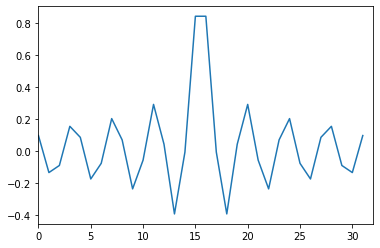

In [ ]:
x = np.linspace(-25.0,25.0,32)
besselJ01D = special.j0(x)
plt.figure()
plt.plot(besselJ01D)
plt.xlim(0,len(besselJ01D))
plt.show()

In [ ]:
dx,dy,dz = np.meshgrid(x,x,x)
x3D = np.sqrt(dx**2+dy**2+dz**2)

besselJ03D =  special.j0(x3D)

A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nulo, uma vez que não há vetores assimétricos.

Diferentemente da PDF normal, os vetores variam de sentido, metade dos vetores simétricos apontam para o centro da matriz e a outra metade aponta para a parte externa da matriz. Sendo assim, $G_3$ é a melhor métrica para distinguir os padrões nesse caso.

In [ ]:
moments = ga(besselJ03D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(besselJ03D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(besselJ03D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(besselJ03D, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente simétrico: {'G1': 6.654, 'G1N': 0.878, 'G2': 0.992, 'G3': 0.973, 'G4': 9355.34611753538 + 2.4935609133081e-13*i + (-1.15740750317173e-14)*j + 7.21428125571855e-16*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 6.654, 'G1N': 0.878, 'G2': 0.911, 'G3': 0.973, 'G4': 9355.34611753538 + 2.4935609133081e-13*i + (-1.15740750317173e-14)*j + 7.21428125571855e-16*k}
Momentos do campo gradiente completo: {'G1': 6.555, 'G1N': 0.876, 'G2': 1.0, 'G3': 0.971}


# 4. Ruídos coloridos

In [6]:
white = cn.powerlaw_psd_gaussian(exponent=0.0, size=(32,32,32))
pink = cn.powerlaw_psd_gaussian(exponent=1.0, size=(32,32,32))
brown = cn.powerlaw_psd_gaussian(exponent=2.0, size=(32,32,32))

In [7]:
moments = ga(white, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(white, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(white, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(white, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Momentos do campo gradiente assimétrico: {'G1': 6.59, 'G1N': 0.877, 'G2': 0.051, 'G3': 0.589, 'G4': 596.088869428029 + 10.963737684452*i + (-20.3916311579476)*j + (-8.63702555656265e-17)*k}
Momentos do campo gradiente simétrico: {'G1': 6.663, 'G1N': 0.878, 'G2': 0.992, 'G3': 0.593, 'G4': 6224.94700719884 + (-9.18105132168848)*i + (-30.2126466554524)*j + (-1.48758356122568e-15)*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 6.672, 'G1N': 0.878, 'G2': 0.97, 'G3': 0.593, 'G4': 6821.03587662687 + 1.78268636276364*i + (-50.6042778134004)*j + (-1.5739538167913e-15)*k}
Momentos do campo gradiente completo: {'G1': 6.667, 'G1N': 0.878, 'G2': 1.0, 'G3': 0.593}


In [8]:
moments = ga(pink, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(pink, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(pink, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(pink, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 6.628, 'G1N': 0.877, 'G2': 0.084, 'G3': 0.586, 'G4': 1062.82095322967 + (-18.4368303292476)*i + 2.96045420845516*j + 3.45379378308835e-16*k}
Momentos do campo gradiente simétrico: {'G1': 6.62, 'G1N': 0.877, 'G2': 0.991, 'G3': 0.593, 'G4': 6963.41699864687 + (-12.7568733814071)*i + (-45.2960677543498)*j + 1.42543363045164e-15*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 6.628, 'G1N': 0.877, 'G2': 0.982, 'G3': 0.592, 'G4': 8026.23795187655 + (-31.193703710655)*i + (-42.3356135458951)*j + 1.77081300876047e-15*k}
Momentos do campo gradiente completo: {'G1': 6.628, 'G1N': 0.877, 'G2': 0.998, 'G3': 0.592}


In [9]:
moments = ga(brown, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(brown, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(brown, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(brown, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 6.5, 'G1N': 0.875, 'G2': 0.033, 'G3': 0.581, 'G4': 309.4651578522 + 3.9310610674025*i + 23.7221930127942*j + 7.34411446587369e-17*k}
Momentos do campo gradiente simétrico: {'G1': 6.6, 'G1N': 0.877, 'G2': 0.991, 'G3': 0.587, 'G4': 5240.15636107439 + (-78.6237308316323)*i + 18.1354671271362*j + 5.94198906454812e-16*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 6.604, 'G1N': 0.877, 'G2': 0.952, 'G3': 0.587, 'G4': 5549.62151892661 + (-74.69266976423)*i + 41.8576601399305*j + 6.67640051113549e-16*k}
Momentos do campo gradiente completo: {'G1': 6.598, 'G1N': 0.877, 'G2': 0.996, 'G3': 0.587}
